# STEP 0

## 0.1. Imports


In [74]:
import pandas                   as pd
import seaborn                  as sns
import sweetviz                 as sv
import matplotlib.pyplot        as plt
from sklearn.svm                import SVC 
from sklearn                    import metrics
from sklearn.pipeline           import Pipeline
from sklearn.model_selection    import GridSearchCV
from sklearn.impute             import SimpleImputer
from sklearn.model_selection    import cross_validate
from sklearn.model_selection    import train_test_split
from sklearn.compose            import ColumnTransformer
from sklearn.model_selection    import StratifiedKFold, KFold
from sklearn.linear_model       import LogisticRegression, LinearRegression
from sklearn.preprocessing      import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.preprocessing      import LabelEncoder, OneHotEncoder, OrdinalEncoder

## 0.2. Helper Functions

In [75]:
# ===================================================================
# Configura os gráficos
def jupyter_settings():
    %matplotlib inline
    # %pylab inline
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [22, 9]
    plt.rcParams['font.size'] = 21

    # display(HTML('<style>.conteiner{width:100% !important;}</style>'))

    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option('display.expand_frame_repr', False)
    
    # configura o pandas para quantidade de casas decimais
    pd.set_option('display.float_format', lambda x: '%.2f' % x)

    sns.set()

jupyter_settings()


# Faz o Cross Validation do modelo e retorna um dataframe com as métricas selecionadas
def kfold_cross_validation(model, model_name, x, y, n_folds=3):
    kf = StratifiedKFold(n_splits=n_folds)    
    y = y.values
    x = x.values
    
    for train, test in kf.split(x, y):
        data_train, target_train = x[train], y[train]
        data_test, target_test   = x[test], y[test]
        
        # Balanceando as classes
        from imblearn.combine import SMOTETomek
        smote_tomek = SMOTETomek(random_state=0)
        data_train, target_train = smote_tomek.fit_resample(data_train, target_train)

        # Aplicando scaler
        mms = MinMaxScaler()
        mms.fit(data_train)
        data_train_norm = mms.transform(data_train)
        data_test_norm = mms.transform(data_test)

        model = model.fit(data_train_norm, target_train)
        out = model.predict(data_test_norm)
        
    data = [
            [
                model_name,
                metrics.precision_score(target_test, out),
                metrics.recall_score(target_test, out),
                metrics.f1_score(target_test, out),
                metrics.roc_auc_score(target_test, out),
            ]
        ]
    
    columns = ["Model", "Precision", "Recall", "F1", "AUC"]
    metrics_table = pd.DataFrame(data, columns=columns)

    # Confusion matrix
    confusion = pd.crosstab(target_test, out, rownames=['Real'], colnames=['Predict'])
    sns.heatmap(confusion, annot=True, fmt='g');

    return metrics_table

# Calcula e retorna um dataframe com as métricas sem validação cruzada
def simple_metrics(model_name, test, predict):
    data = [
        [
            model_name,
            metrics.precision_score(test, predict),
            metrics.recall_score(test, predict),
            metrics.f1_score(test, predict),
            metrics.roc_auc_score(test, predict),
        ]
    ]
    columns = ["Model", "Precision", "Recall", "F1", "AUC"]
    metrics_table = pd.DataFrame(data, columns=columns)
    return metrics_table


def tuning_hyperparams(pre_processor, modelo, model_name, param, X, y):
    '''
        Método que utiliza o Pipeline para pré processar os dados e calcula quais são 
        os melhores hiperparâmetros baseado no modelo e no dicionário de hiperparâmetros 
        informados. Retorna um dicionário com os parâmetros testados e os melhores valores
        de cada um.

        pre_processor: objeto da classe ColumnTransformer escolhido para os dados
        modelo: instância do algoritimo a ser usado
        model_name: String com o apelido do modelo a ser usado
        param: Dict - dicionário com os hiperparams e os valores a serem testados
        X: dados de treino
        y: variável target dos dados de treino

        return dict
    '''
    # criando o modelo usando pipeline
    model = Pipeline(
        steps=[
            ("preprocessor", pre_processor),
            (model_name, modelo),
        ]
    )

    # Criando o dicionario de hiperparâmetros
    test_keys = [model_name + '__' + x for x in param.keys()] # colocar duplo underscore entre o nome do modelo e o nome do parâmetro  (lr__)
    test_values = list(param.values())
    parameters = { test_keys[i]: test_values[i] for i in range(len(test_keys)) }

    # Rodando 5-fold cross-validation com gridsearch
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    grid = GridSearchCV(
        model, param_grid=parameters, cv=kfold, n_jobs=-1, return_train_score=True
    )

    grid.fit(X=X, y=y)

    # Imprime os melhores parâmetros
    param = grid.best_params_
    return param

## 0.3. Loading Data

In [76]:
meta_raw = pd.read_csv('../data/metadata.csv')
df_raw = pd.read_csv('../data/train.csv')

# 1 - Data understanding


In [77]:
df = df_raw.copy()
meta = meta_raw.copy()
df.head(3)

,id,var1,var2,var3,var4,var5,var6,var7,var8,var9,var10,var11,var12,var13,var14,var15,var16,var17,var18,var19,var20,var21,var22,var23,var24,var25,var26,var27,var28,var29,var30,var31,var32,var33,var34,var35,var36,var37,var38,var39,var40,var41,var42,var43,var44,var45,var46,var47,var48,var49,var50,var51,var52,var53,var54,var55,var56,var57,var58,var59,var60,var61,var62,var63,var64,var65,var66,var67,var68,y
0,1,18,19,2853,29442,1386,2435,35,-999,3,63,6498,1166,2007,26,13,11,11,4,1547,26,2068,1,3,0,4,7,0,24,4,2,0,16,3,44,463,27,2,0,4,9,3,25,6,1,4,3,1,0,0,0,0,42,1,1,0.21,0.14,0.83,0.04,0.06,0.31,0.14,0.06,0.63,0.02,0.25,0.01,0.13,0.14,1
1,8,4,110,1986,13684,7189,-999,-999,17,3,63,13989,497,2289,16,1,3,3,3,1797,16,2417,5,1,2,1,6,1,4,2,1,0,14,0,1,532,2,1,0,4,7,3,30,3,0,0,0,0,0,0,0,0,20,1,1,0.23,0.31,0.31,0.07,0.25,-999.00,-999.00,0.07,0.77,0.02,-999.00,-999.00,0.15,0.11,0
2,30,0,39,1019,10232,678,791,16,-999,3,63,9739,562,641,10,34,34,10,4,511,10,664,5,3,2,1,7,0,3,4,1,0,11,1,3,81,26,3,0,4,3,3,23,5,1,0,0,0,0,0,0,0,12,1,1,0.20,0.21,0.45,0.02,0.21,-999.00,0.20,0.05,0.98,0.02,-999.00,-999.00,0.38,0.24,0


In [78]:
meta.head()

,Variavel cod,Variavel tipo
0,id,Qualitativo nominal
1,var1,Qualitativo nominal
2,var2,Qualitativo nominal
3,var3,Qualitativo nominal
4,var4,Qualitativo nominal


## 1.1. Rename Columns

In [79]:
# Separa o nome composto da variável
meta['Variavel tipo'] = meta['Variavel tipo'].apply( lambda x: x.split()[1] )

# Ordena por nome
meta_sorted = meta.sort_values('Variavel tipo')

# Acrescenta um número sequencial no nome da variável
nome = []
contador = 1
for tipo in meta_sorted['Variavel tipo'][:12]:
    nome.append(tipo + '_' + str(contador))
    contador += 1

contador = 1
for tipo in meta_sorted['Variavel tipo'][12:30]:
    nome.append(tipo + '_' + str(contador))
    contador += 1

contador = 1
for tipo in meta_sorted['Variavel tipo'][30:66]:
    nome.append(tipo + '_' + str(contador))
    contador += 1

contador = 1
for tipo in meta_sorted['Variavel tipo'][66:]:
    nome.append(tipo + '_' + str(contador))
    contador += 1

meta_sorted['novo_nome'] = nome
meta_sorted['novo_nome'] = meta_sorted.apply( lambda x: x['novo_nome'] if ((x['Variavel cod'] != 'id') & (x['Variavel cod'] != 'y')) else x['Variavel cod'], axis=1 )
meta = meta_sorted.sort_index()

In [80]:
df2 = df.copy()
df2.columns = meta.novo_nome.values
df2.head()

,id,nominal_8,nominal_9,nominal_10,nominal_11,nominal_12,nominal_13,nominal_14,nominal_15,nominal_16,nominal_17,nominal_18,nominal_19,nominal_20,nominal_21,nominal_22,nominal_23,nominal_24,nominal_35,nominal_34,nominal_33,nominal_32,nominal_31,nominal_36,discreto_2,discreto_3,ordinal_1,discreto_5,nominal_28,nominal_27,nominal_26,nominal_25,ordinal_3,nominal_7,nominal_30,nominal_29,nominal_1,nominal_5,nominal_4,nominal_3,discreto_7,nominal_2,ordinal_2,ordinal_4,discreto_8,discreto_1,discreto_6,discreto_9,discreto_17,discreto_11,discreto_12,discreto_10,discreto_13,discreto_14,discreto_15,continua_12,continua_11,continua_10,continua_1,continua_9,continua_8,continua_7,continua_6,continua_5,continua_4,continua_3,continua_2,discreto_16,discreto_18,y
0,1,18,19,2853,29442,1386,2435,35,-999,3,63,6498,1166,2007,26,13,11,11,4,1547,26,2068,1,3,0,4,7,0,24,4,2,0,16,3,44,463,27,2,0,4,9,3,25,6,1,4,3,1,0,0,0,0,42,1,1,0.21,0.14,0.83,0.04,0.06,0.31,0.14,0.06,0.63,0.02,0.25,0.01,0.13,0.14,1
1,8,4,110,1986,13684,7189,-999,-999,17,3,63,13989,497,2289,16,1,3,3,3,1797,16,2417,5,1,2,1,6,1,4,2,1,0,14,0,1,532,2,1,0,4,7,3,30,3,0,0,0,0,0,0,0,0,20,1,1,0.23,0.31,0.31,0.07,0.25,-999.00,-999.00,0.07,0.77,0.02,-999.00,-999.00,0.15,0.11,0
2,30,0,39,1019,10232,678,791,16,-999,3,63,9739,562,641,10,34,34,10,4,511,10,664,5,3,2,1,7,0,3,4,1,0,11,1,3,81,26,3,0,4,3,3,23,5,1,0,0,0,0,0,0,0,12,1,1,0.20,0.21,0.45,0.02,0.21,-999.00,0.20,0.05,0.98,0.02,-999.00,-999.00,0.38,0.24,0
3,43,20,39,1751,2689,8235,1042,13,10,1,14,2890,6541,811,8,59,60,23,5,624,8,839,0,0,0,0,1,1,19,1,2,0,8,0,11,414,27,0,0,4,10,3,22,10,1,1,1,0,1,1,0,0,36,1,1,0.21,0.72,0.10,0.20,0.35,-999.00,0.35,0.04,0.95,0.02,0.36,0.00,0.15,0.13,0
4,46,7,44,2262,29428,6031,304,16,-999,3,63,13541,7238,260,10,55,56,20,5,1413,10,270,2,3,2,1,8,1,3,4,1,0,17,4,3,567,8,3,2,4,5,3,26,5,1,0,0,0,0,1,0,0,19,1,1,0.22,0.60,0.10,0.14,0.19,0.02,0.23,0.06,0.91,0.02,-999.00,-999.00,0.46,0.13,1


## 1.2. Data Dimensions

In [81]:
# Conferindo a volumetria
print(f"Quantidade de linhas:   {df2.shape[0]}")
print(f"Quantidade de colunas:  {df2.shape[1]}")
print(f"IDs únicos:             {df2.id.nunique()}\n")

Quantidade de linhas:   14123
Quantidade de colunas:  70
IDs únicos:             14123



## 1.3. Data Types

In [82]:
df2.dtypes

id               int64
nominal_8        int64
nominal_9        int64
nominal_10       int64
nominal_11       int64
nominal_12       int64
nominal_13       int64
nominal_14       int64
nominal_15       int64
nominal_16       int64
nominal_17       int64
nominal_18       int64
nominal_19       int64
nominal_20       int64
nominal_21       int64
nominal_22       int64
nominal_23       int64
nominal_24       int64
nominal_35       int64
nominal_34       int64
nominal_33       int64
nominal_32       int64
nominal_31       int64
nominal_36       int64
discreto_2       int64
discreto_3       int64
ordinal_1        int64
discreto_5       int64
nominal_28       int64
nominal_27       int64
nominal_26       int64
nominal_25       int64
ordinal_3        int64
nominal_7        int64
nominal_30       int64
nominal_29       int64
nominal_1        int64
nominal_5        int64
nominal_4        int64
nominal_3        int64
discreto_7       int64
nominal_2        int64
ordinal_2        int64
ordinal_4  

## 1.4. Change Data Types

In [83]:
'''
Alterando os tipos de int64 e float64 para int32 e float32 respectivamente com o 
intuito de melhorar a performance além de alterar as variáveis nominais para o tipo 
category que consome menos memória que o tipo object.
'''

# Reduzindo tamanho para performance
for col in df2.columns[:56]:
    df2[col] = df2[col].astype('int32')
for col in df2.columns[56:-1]:
    df2[col] = df2[col].astype('float32')
df2.y = df2.y.astype('int32')

# Convertendo variáveis nominais para category
for col in df2.columns[1:24]:
    df2[col] = df2[col].astype('category')
for col in df2.columns[28:40]:
    df2[col] = df2[col].astype('category')
for col in df2.columns[41:42]:
    df2[col] = df2[col].astype('category')

## 1.5. Check NA


In [84]:
df2.isnull().sum()

id             0
nominal_8      0
nominal_9      0
nominal_10     0
nominal_11     0
nominal_12     0
nominal_13     0
nominal_14     0
nominal_15     0
nominal_16     0
nominal_17     0
nominal_18     0
nominal_19     0
nominal_20     0
nominal_21     0
nominal_22     0
nominal_23     0
nominal_24     0
nominal_35     0
nominal_34     0
nominal_33     0
nominal_32     0
nominal_31     0
nominal_36     0
discreto_2     0
discreto_3     0
ordinal_1      0
discreto_5     0
nominal_28     0
nominal_27     0
nominal_26     0
nominal_25     0
ordinal_3      0
nominal_7      0
nominal_30     0
nominal_29     0
nominal_1      0
nominal_5      0
nominal_4      0
nominal_3      0
discreto_7     0
nominal_2      0
ordinal_2      0
ordinal_4      0
discreto_8     0
discreto_1     0
discreto_6     0
discreto_9     0
discreto_17    0
discreto_11    0
discreto_12    0
discreto_10    0
discreto_13    0
discreto_14    0
discreto_15    0
continua_12    0
continua_11    0
continua_10    0
continua_1    

## 1.6. Descriptive Statistical


In [85]:
# Separando os atributos entre numéricos e categóricos

numerical_attributes = df2[
    ['continua_1', 'continua_10', 'continua_11', 'continua_12', 'continua_2',
       'continua_3', 'continua_4', 'continua_5', 'continua_6', 'continua_7',
       'continua_8', 'continua_9', 'discreto_1', 'discreto_10', 'discreto_11',
       'discreto_12', 'discreto_13', 'discreto_14', 'discreto_15',
       'discreto_16', 'discreto_17', 'discreto_18', 'discreto_2', 'discreto_3',
       'discreto_5', 'discreto_6', 'discreto_7', 'discreto_8', 'discreto_9']]


categorical_attributes = df2.drop(
    columns=['continua_1', 'continua_10', 'continua_11', 'continua_12', 'continua_2',
       'continua_3', 'continua_4', 'continua_5', 'continua_6', 'continua_7',
       'continua_8', 'continua_9', 'discreto_1', 'discreto_10', 'discreto_11',
       'discreto_12', 'discreto_13', 'discreto_14', 'discreto_15', 'discreto_16', 
       'discreto_17', 'discreto_18', 'discreto_2', 'discreto_3', 'discreto_5', 
       'discreto_6', 'discreto_7', 'discreto_8', 'discreto_9', 'id', 'y'])

### 1.6.1 Numerical Features

In [86]:
numerical_attributes.describe().T

,count,mean,std,min,25%,50%,75%,max
continua_1,14123.00,-111.02,314.16,-999.00,0.02,0.05,0.14,1.00
continua_10,14123.00,-112.09,315.80,-999.00,0.03,0.10,0.45,1.00
continua_11,14123.00,-111.82,315.67,-999.00,0.12,0.37,0.78,1.00
continua_12,14123.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00
continua_2,14123.00,-862.76,342.86,-999.00,-999.00,-999.00,-999.00,1.00
continua_3,14123.00,-862.72,342.96,-999.00,-999.00,-999.00,-999.00,1.00
continua_4,14123.00,0.03,0.02,0.00,0.02,0.02,0.03,0.39
continua_5,14123.00,0.78,0.23,0.00,0.71,0.88,0.93,1.00
continua_6,14123.00,0.07,0.05,0.00,0.04,0.06,0.09,0.81
continua_7,14123.00,-24.21,154.49,-999.00,0.17,0.24,0.34,0.93


### 1.6.2 Categorical Features

In [87]:
display( pd.DataFrame( categorical_attributes.apply(lambda x: x.unique().shape[0]), columns=[ 'Valores únicos'], ).sort_values('Valores únicos'))

,Valores únicos
nominal_25,2
nominal_26,3
nominal_16,4
nominal_36,5
nominal_3,6
nominal_27,6
nominal_31,6
nominal_7,7
nominal_35,7
nominal_2,10


### 1.7 Target Feature

In [88]:
df2.y.value_counts()

0    11273
1     2850
Name: y, dtype: int64

# 2 - Exploratory data analisys

In [89]:
my_report = sv.analyze(df2, target_feat ='y')
my_report.show_html()

c:\Users\Usuário\repos\compass\lib\site-packages\sweetviz\dataframe_report.py:74: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  all_source_names = [cur_name for cur_name, cur_series in source_df.iteritems()]
c:\Users\Usuário\repos\compass\lib\site-packages\sweetviz\dataframe_report.py:109: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  filtered_series_names_in_source = [cur_name for cur_name, cur_series in source_df.iteritems()
Feature: y (TARGET)                          |▏         | [  1%]   00:00 -> (00:04 left)c:\Users\Usuário\repos\compass\lib\site-packages\sweetviz\series_analyzer_cat.py:28: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for item in category_counts.iteritems():
Feature: id                                  |▎         | [  3%]   00:00 -> (00:15 left)c:\Users\Usuário\repos\compass\lib\site-packages\swee

Report SWEETVIZ_REPORT.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


## 2.1. Análise Univariada

Variáveis contínuas não afetudas pelos valores marcadores (-999)


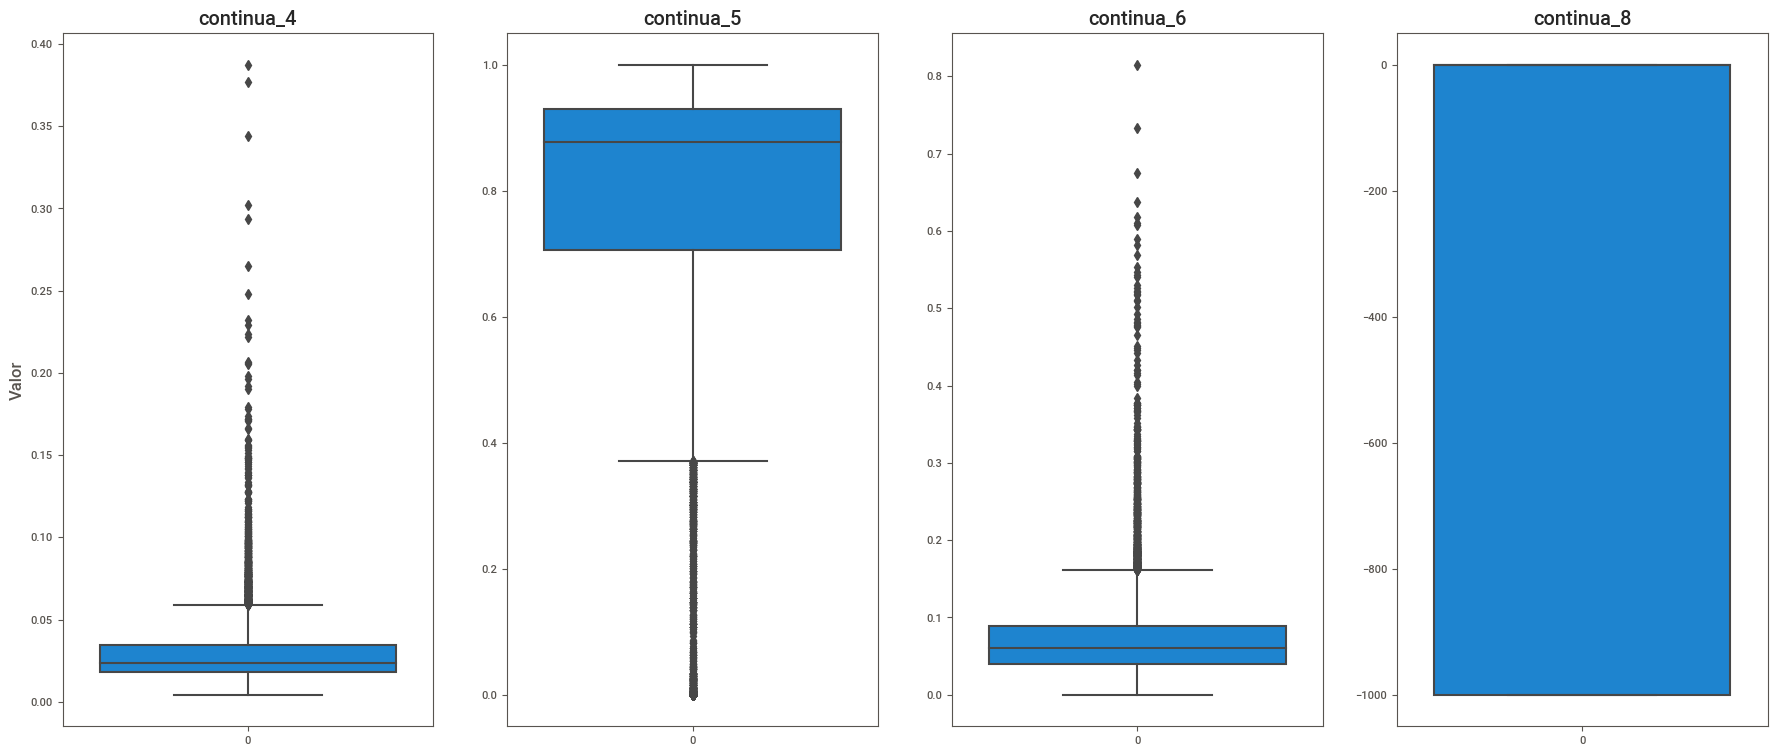

In [90]:
plt.subplot(1,4,1)
sns.boxplot(numerical_attributes['continua_4']).set(title='continua_4', ylabel="Valor")

plt.subplot(1,4,2)
sns.boxplot(numerical_attributes['continua_5']).set(title='continua_5',)

plt.subplot(1,4,3)
sns.boxplot(numerical_attributes['continua_6']).set(title='continua_6')

plt.subplot(1,4,4)
sns.boxplot(numerical_attributes['continua_8']).set(title='continua_8',);

print("Variáveis contínuas não afetudas pelos valores marcadores (-999)")

Variáveis contínuas afetadas pelos valores marcadores (-999)


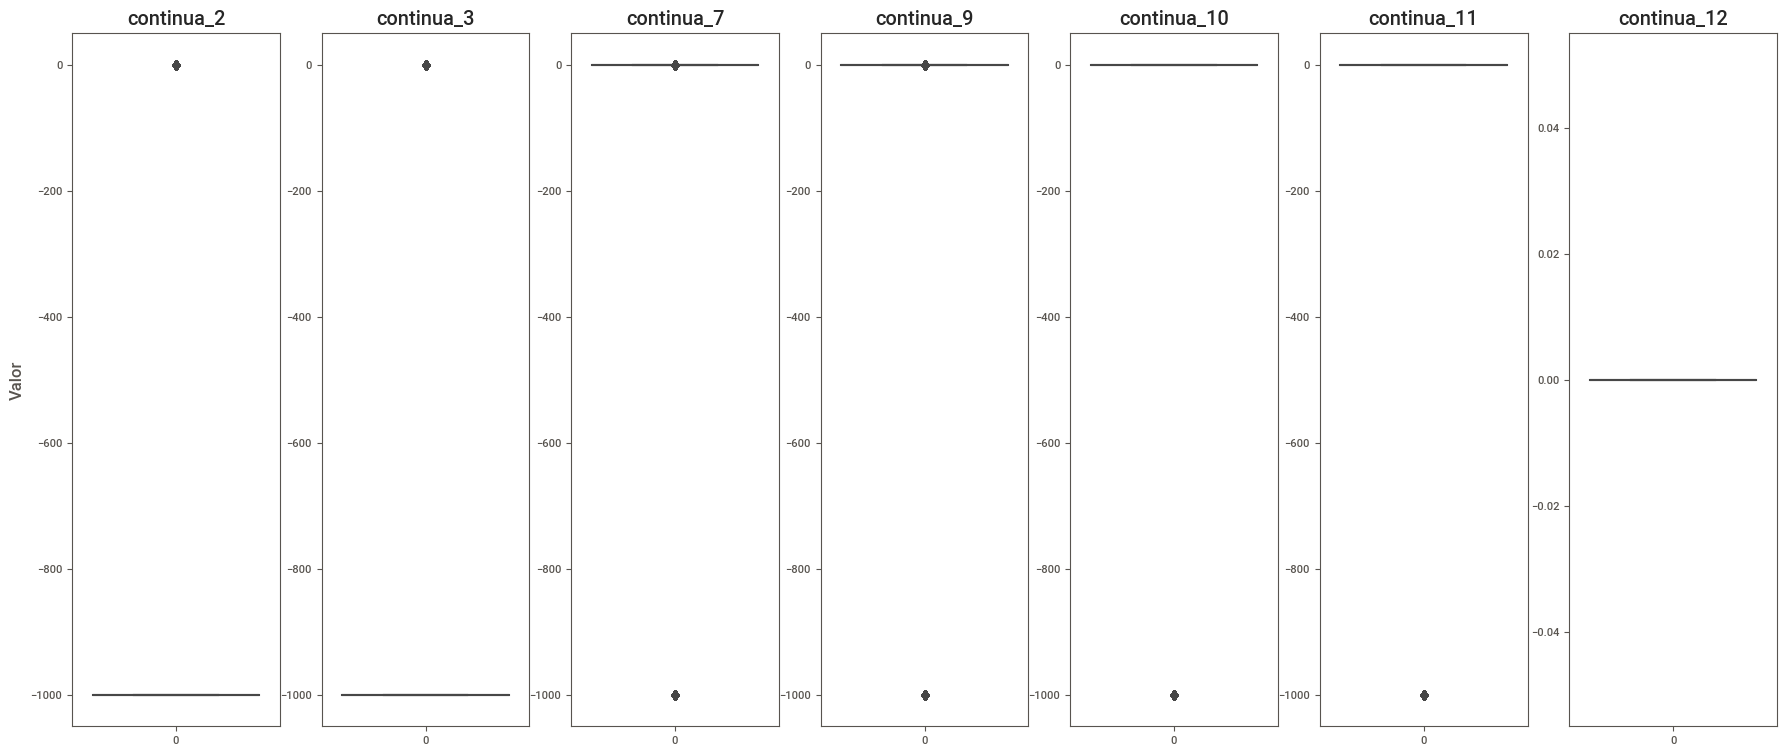

In [91]:
plt.subplot(1,7,1)
sns.boxplot(numerical_attributes['continua_2']).set(title='continua_2', ylabel="Valor")

plt.subplot(1,7,2)
sns.boxplot(numerical_attributes['continua_3']).set(title='continua_3')

plt.subplot(1,7,3)
sns.boxplot(numerical_attributes['continua_7']).set(title='continua_7')

plt.subplot(1,7,4)
sns.boxplot(numerical_attributes['continua_9']).set(title='continua_9')

plt.subplot(1,7,5)
sns.boxplot(numerical_attributes['continua_10']).set(title='continua_10')

plt.subplot(1,7,6)
sns.boxplot(numerical_attributes['continua_11']).set(title='continua_11')

plt.subplot(1,7,7)
sns.boxplot(numerical_attributes['continua_12']).set(title='continua_12');

print("Variáveis contínuas afetadas pelos valores marcadores (-999)")

Variáveis contínuas afetadas sem os valores marcadores (-999)


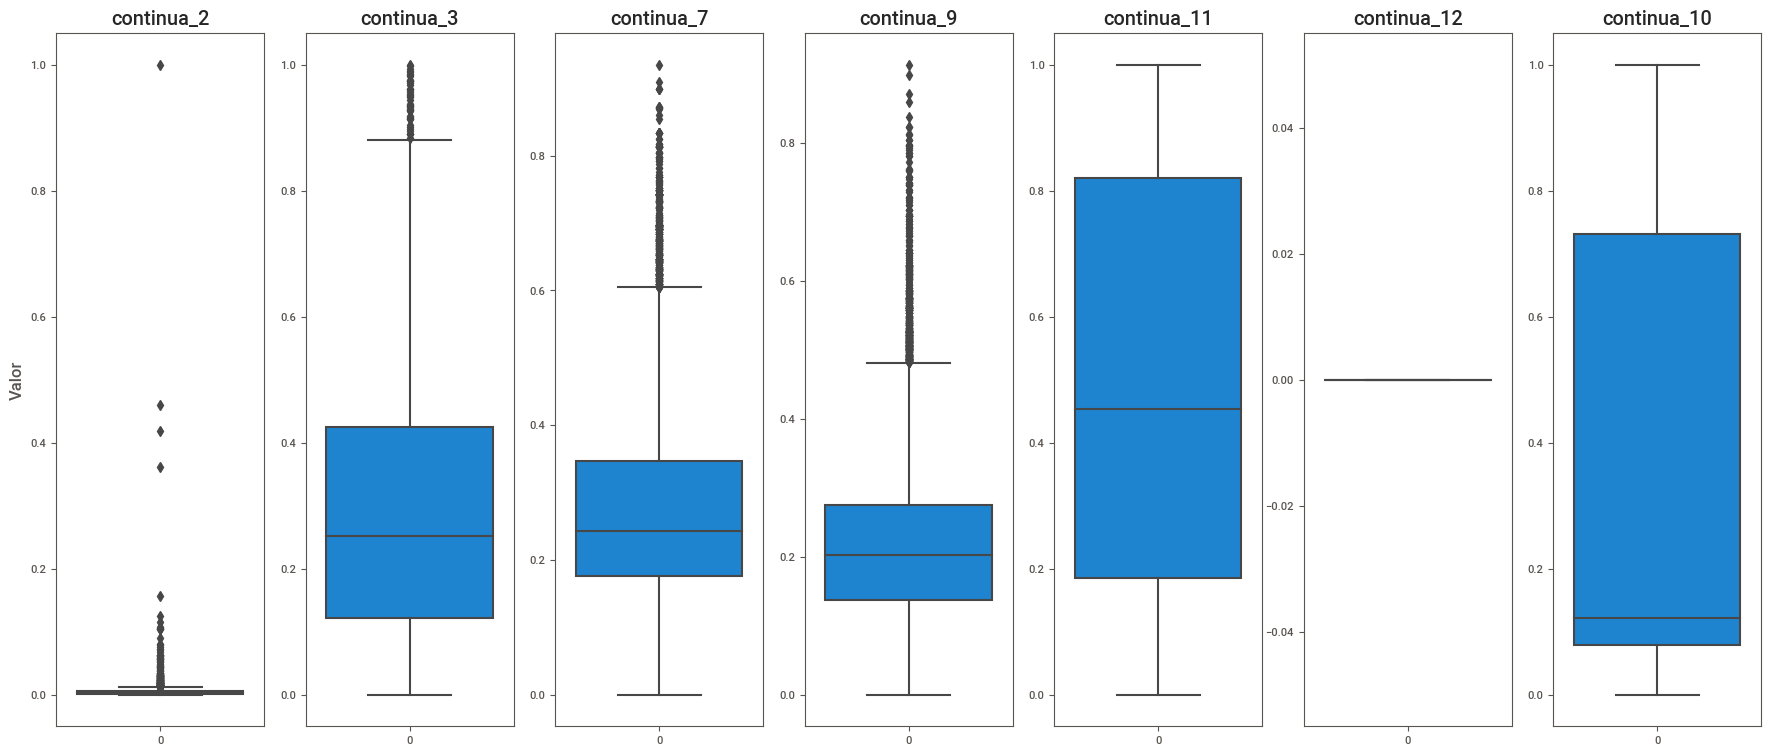

In [92]:
plt.subplot(1,7,1)
sns.boxplot(numerical_attributes[numerical_attributes['continua_2'] > -1]['continua_2']).set(title='continua_2', ylabel="Valor")

plt.subplot(1,7,2)
sns.boxplot(numerical_attributes[numerical_attributes['continua_3'] > -1]['continua_3']).set(title='continua_3')

plt.subplot(1,7,3)
sns.boxplot(numerical_attributes[numerical_attributes['continua_7'] > -1]['continua_7']).set(title='continua_7')

plt.subplot(1,7,4)
sns.boxplot(numerical_attributes[numerical_attributes['continua_9'] > -1]['continua_9']).set(title='continua_9')

plt.subplot(1,7,5)
sns.boxplot(numerical_attributes[numerical_attributes['continua_11'] > -1]['continua_11']).set(title='continua_11')

plt.subplot(1,7,6)
sns.boxplot(numerical_attributes[numerical_attributes['continua_12'] > -1]['continua_12']).set(title='continua_12')

plt.subplot(1,7,7)
sns.boxplot(numerical_attributes[numerical_attributes['continua_10'] > -1]['continua_10']).set(title='continua_10');

print('Variáveis contínuas afetadas sem os valores marcadores (-999)')

Variáveis discretas não afetadas pelos valores marcadores (-999)


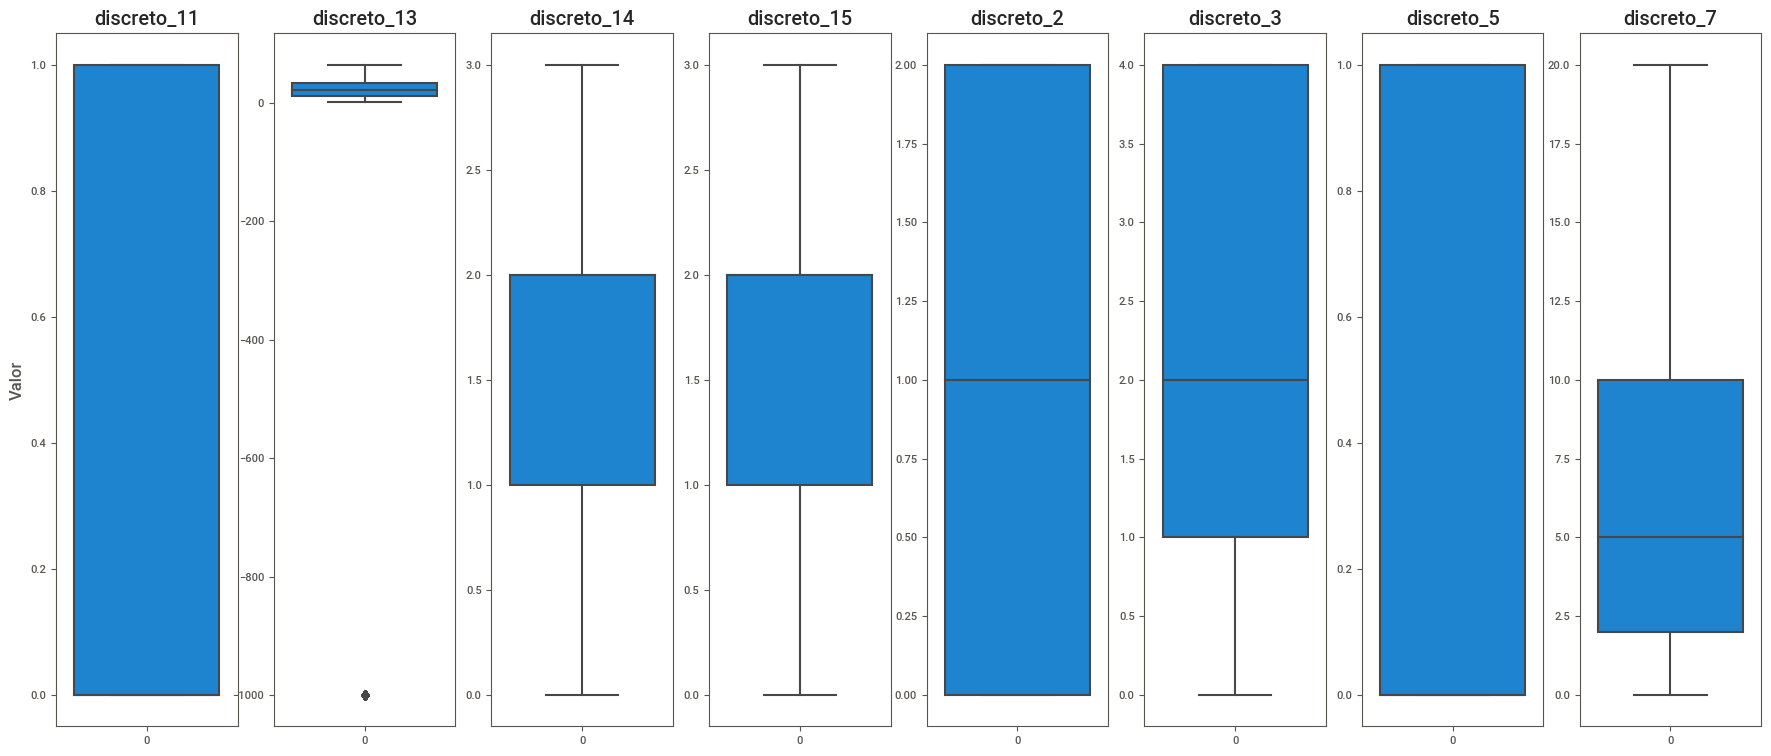

In [93]:
plt.subplot(1,8,1)
sns.boxplot(numerical_attributes['discreto_11']).set(title='discreto_11', ylabel="Valor")

plt.subplot(1,8,2)
sns.boxplot(numerical_attributes['discreto_13']).set(title='discreto_13')

plt.subplot(1,8,3)
sns.boxplot(numerical_attributes['discreto_14']).set(title='discreto_14')

plt.subplot(1,8,4)
sns.boxplot(numerical_attributes['discreto_15']).set(title='discreto_15')

plt.subplot(1,8,5)
sns.boxplot(numerical_attributes['discreto_2']).set(title='discreto_2')

plt.subplot(1,8,6)
sns.boxplot(numerical_attributes['discreto_3']).set(title='discreto_3')

plt.subplot(1,8,7)
sns.boxplot(numerical_attributes['discreto_5']).set(title='discreto_5')

plt.subplot(1,8,8)
sns.boxplot(numerical_attributes['discreto_7']).set(title='discreto_7');

print('Variáveis discretas não afetadas pelos valores marcadores (-999)')

Variáveis discretas afetadas pelos valores marcadores (-999)


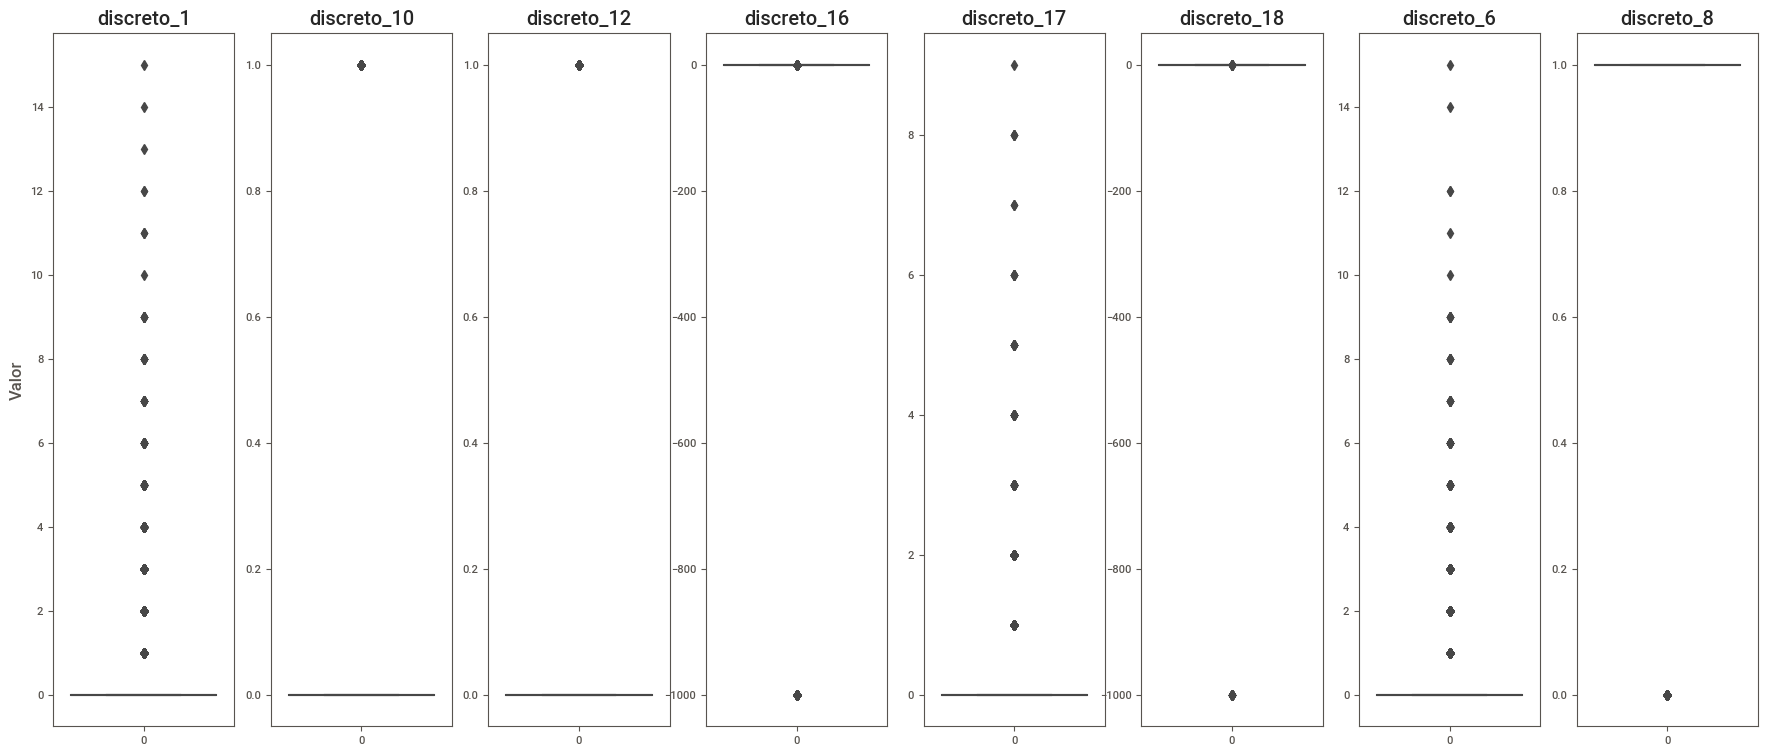

In [94]:
plt.subplot(1,8,1)
sns.boxplot(numerical_attributes['discreto_1']).set(title='discreto_1', ylabel="Valor")

plt.subplot(1,8,2)
sns.boxplot(numerical_attributes['discreto_10']).set(title='discreto_10')

plt.subplot(1,8,3)
sns.boxplot(numerical_attributes['discreto_12']).set(title='discreto_12')

plt.subplot(1,8,4)
sns.boxplot(numerical_attributes['discreto_16']).set(title='discreto_16')

plt.subplot(1,8,5)
sns.boxplot(numerical_attributes['discreto_17']).set(title='discreto_17')

plt.subplot(1,8,6)
sns.boxplot(numerical_attributes['discreto_18']).set(title='discreto_18')

plt.subplot(1,8,7)
sns.boxplot(numerical_attributes['discreto_6']).set(title='discreto_6')

plt.subplot(1,8,8)
sns.boxplot(numerical_attributes['discreto_8']).set(title='discreto_8');

print('Variáveis discretas afetadas pelos valores marcadores (-999)')

Variáveis discretas afetadas sem os valores marcadores (-999)


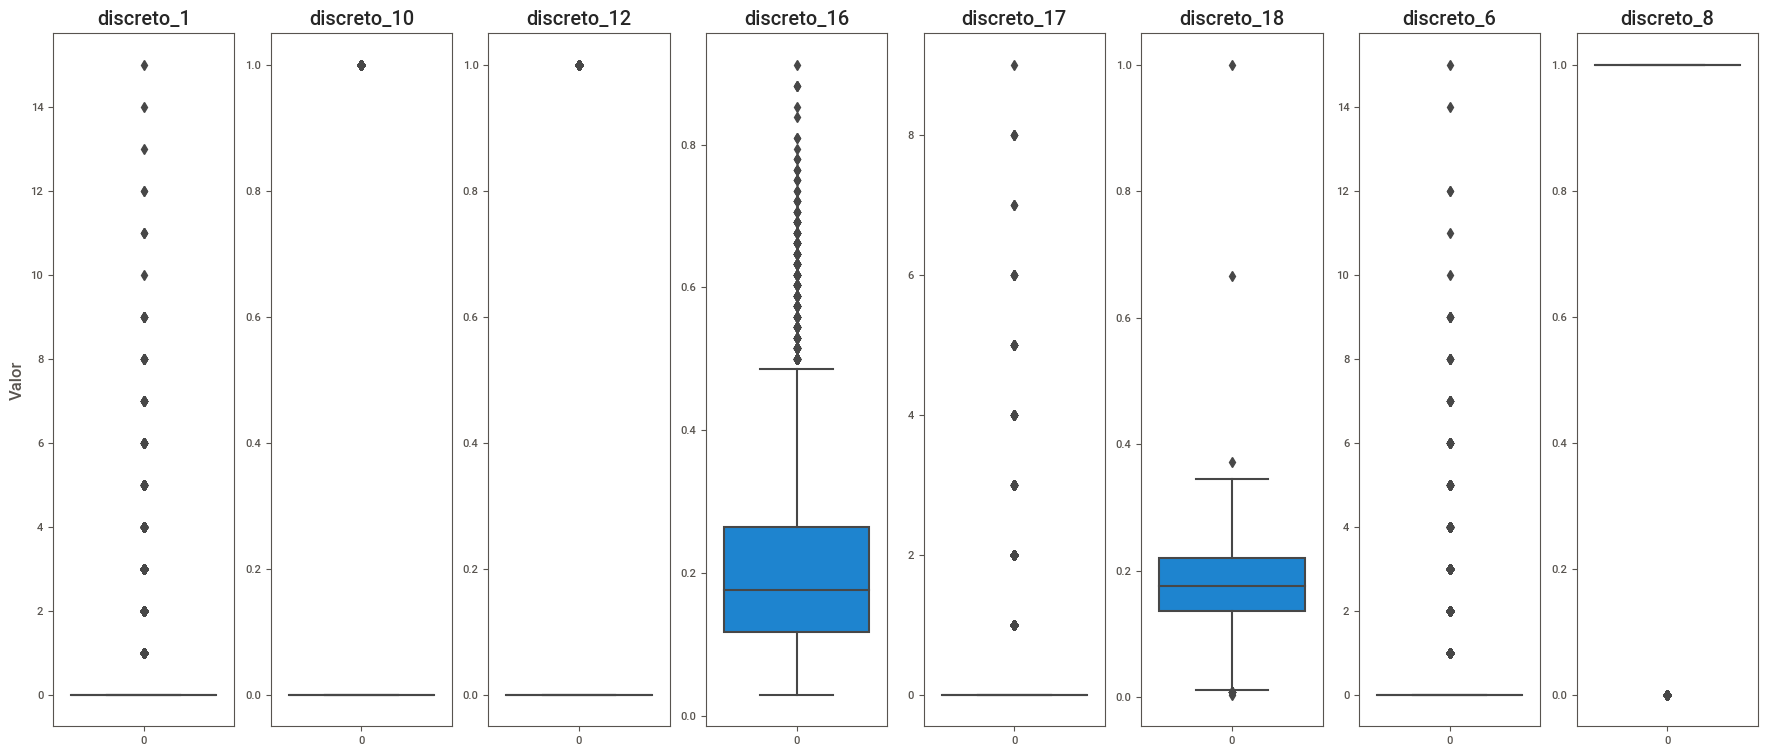

In [95]:
plt.subplot(1,8,1)
sns.boxplot(numerical_attributes[numerical_attributes['discreto_1'] > -1]['discreto_1']).set(title='discreto_1', ylabel="Valor")

plt.subplot(1,8,2)
sns.boxplot(numerical_attributes[numerical_attributes['discreto_10'] > -1]['discreto_10']).set(title='discreto_10')

plt.subplot(1,8,3)
sns.boxplot(numerical_attributes[numerical_attributes['discreto_12'] > -1]['discreto_12']).set(title='discreto_12')

plt.subplot(1,8,4)
sns.boxplot(numerical_attributes[numerical_attributes['discreto_16'] > -1]['discreto_16']).set(title='discreto_16')

plt.subplot(1,8,5)
sns.boxplot(numerical_attributes[numerical_attributes['discreto_17'] > -1]['discreto_17']).set(title='discreto_17')

plt.subplot(1,8,6)
sns.boxplot(numerical_attributes[numerical_attributes['discreto_18'] > -1]['discreto_18']).set(title='discreto_18')

plt.subplot(1,8,7)
sns.boxplot(numerical_attributes[numerical_attributes['discreto_6'] > -1]['discreto_6']).set(title='discreto_6')

plt.subplot(1,8,8)
sns.boxplot(numerical_attributes[numerical_attributes['discreto_8'] > -1]['discreto_8']).set(title='discreto_8');

print('Variáveis discretas afetadas sem os valores marcadores (-999)')

Verificando a variância das features


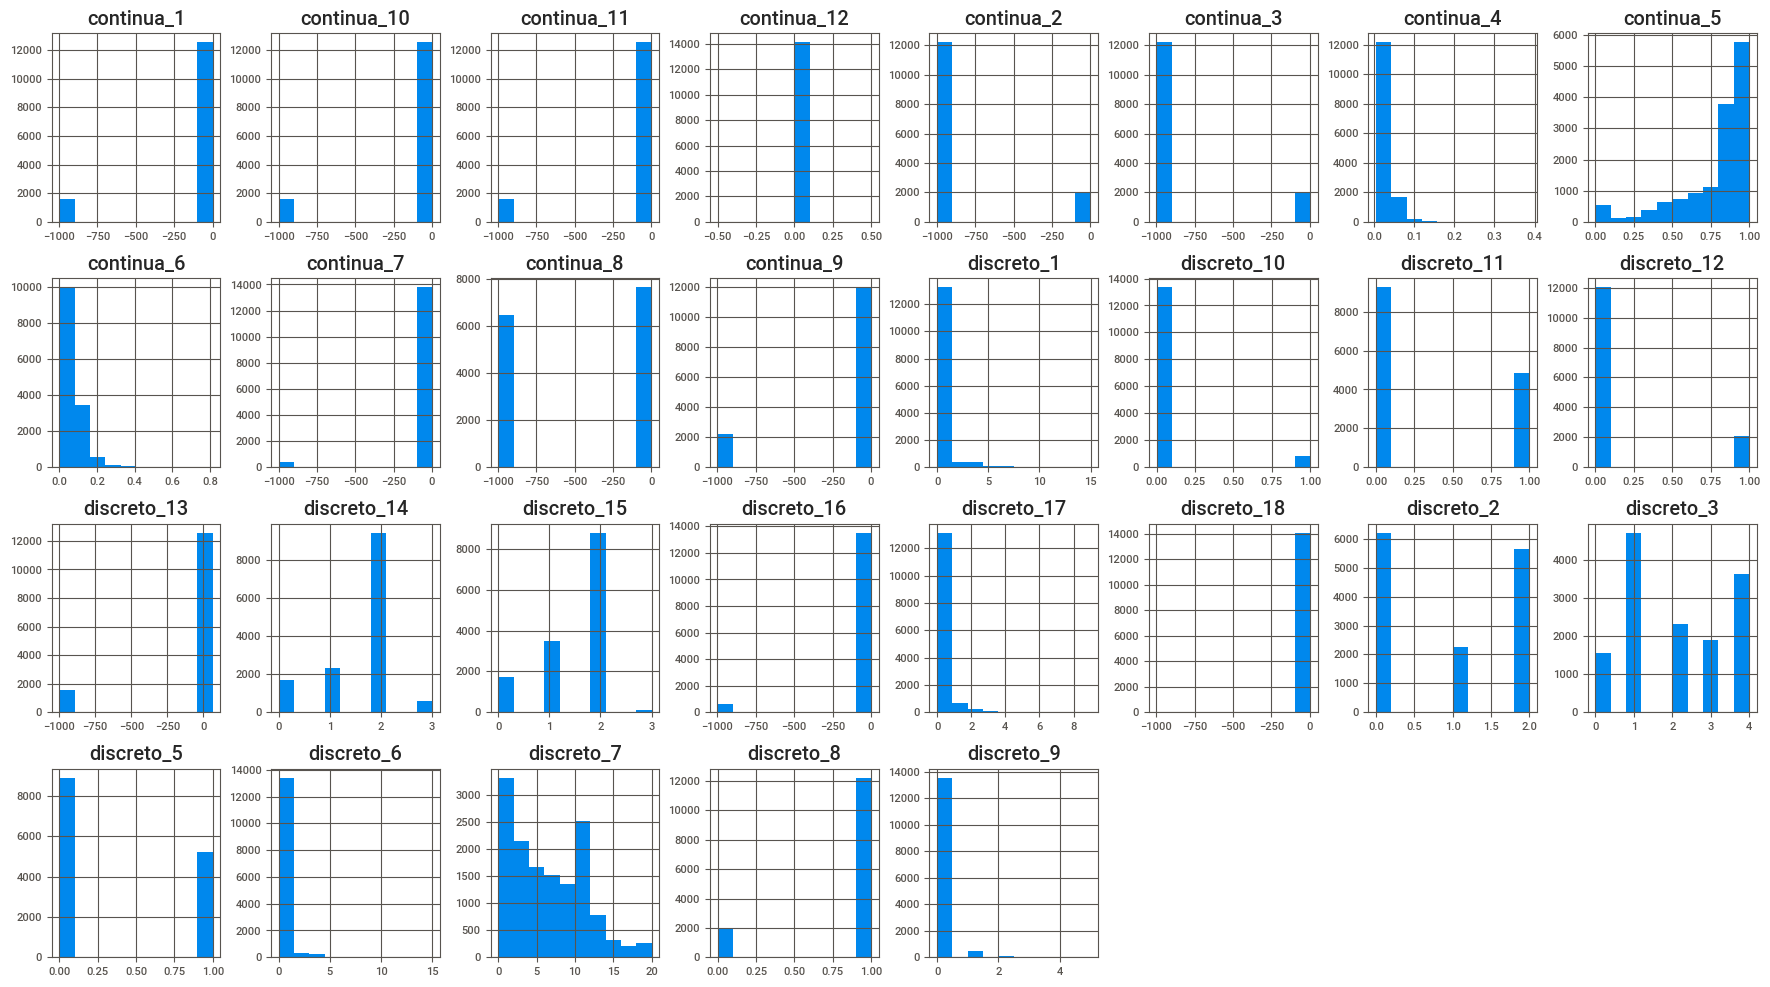

In [96]:
numerical_attributes.hist(figsize=(22,12),layout=(4,8));
print('Verificando a variância das features')

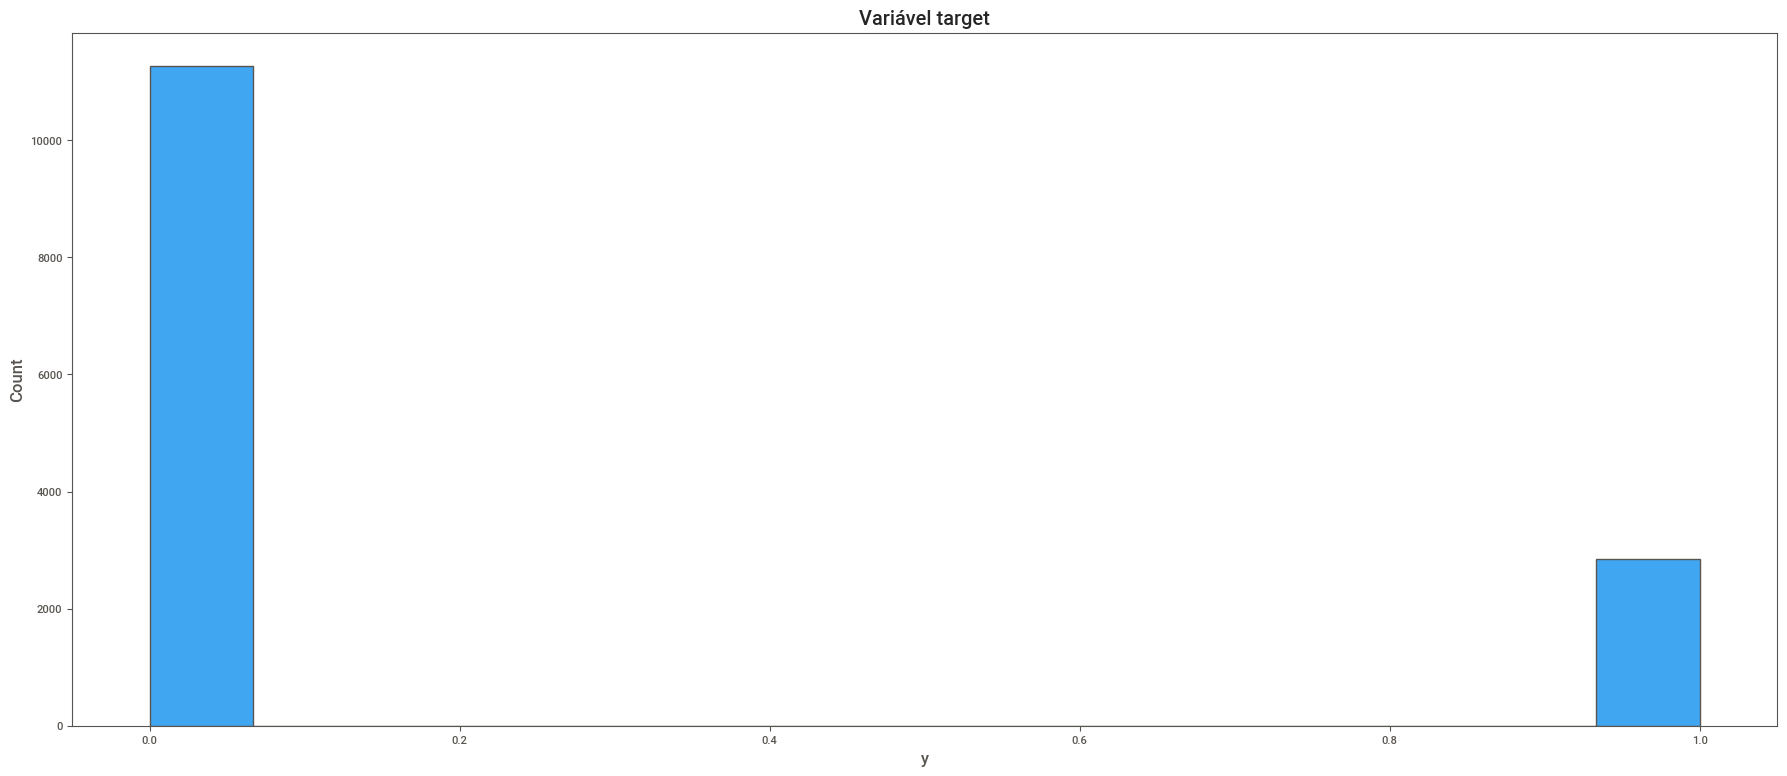

In [97]:
sns.histplot(df2.y).set(title="Variável target");


## 2.2. Análise Bivariada

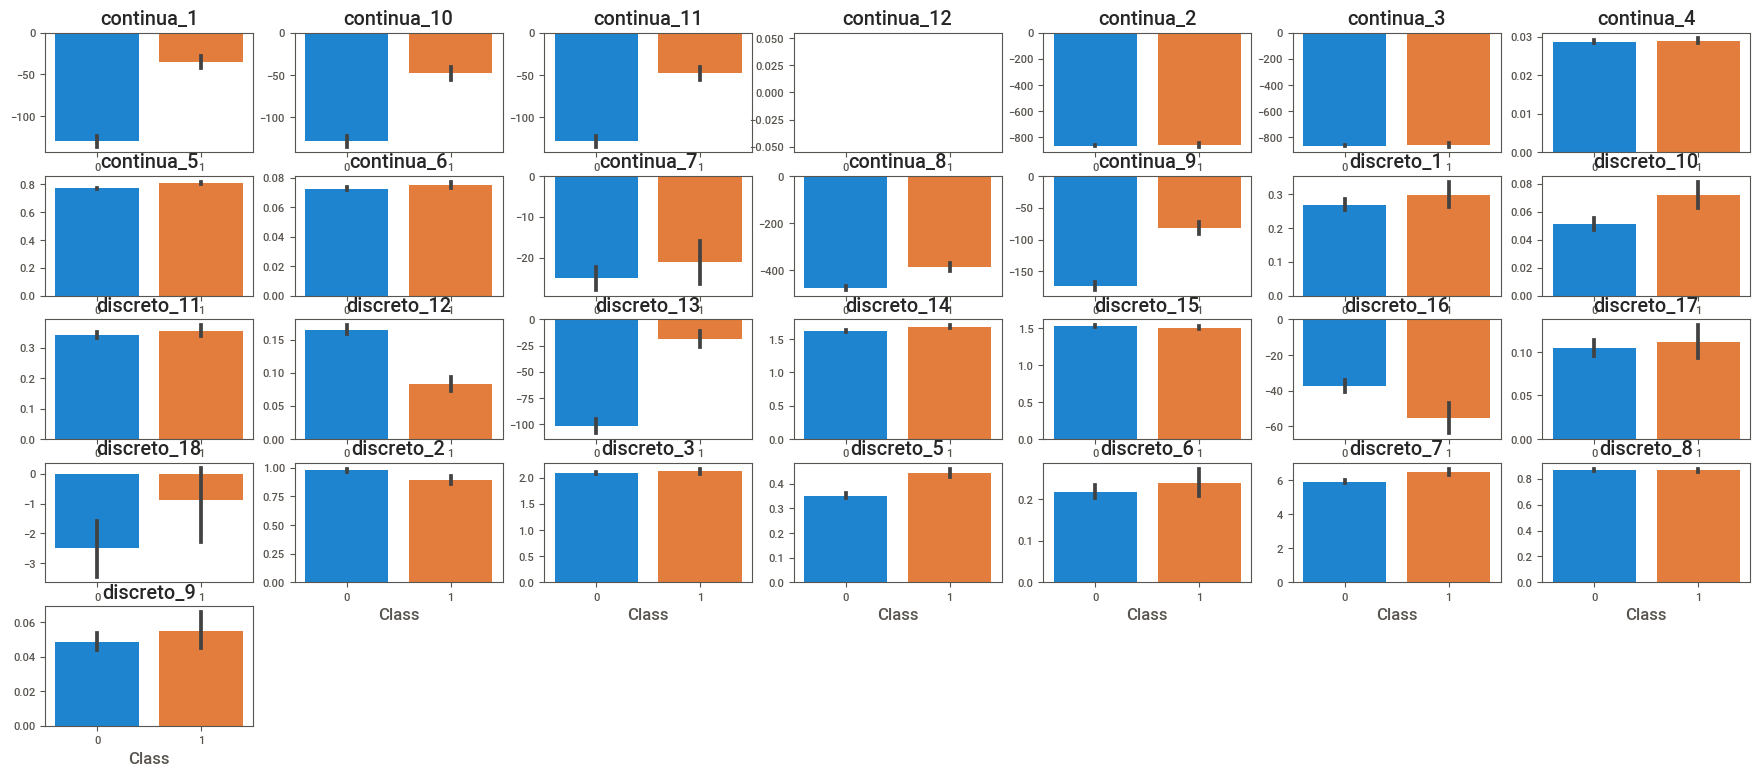

In [98]:
counter = 1
for col in numerical_attributes.columns:
    plt.subplot(5, 7, counter)
    sns.barplot(data=df2, y=col,  x="y").set(title=col, xlabel="Class", ylabel=None);
    counter += 1


## 2.3. Análise Multivariada

In [99]:
corr = numerical_attributes.corr().round(1)
corr

,continua_1,continua_10,continua_11,continua_12,continua_2,continua_3,continua_4,continua_5,continua_6,continua_7,continua_8,continua_9,discreto_1,discreto_10,discreto_11,discreto_12,discreto_13,discreto_14,discreto_15,discreto_16,discreto_17,discreto_18,discreto_2,discreto_3,discreto_5,discreto_6,discreto_7,discreto_8,discreto_9
continua_1,1.00,0.70,0.70,NaN,0.10,0.10,0.00,0.00,0.00,0.00,0.30,0.60,0.10,0.00,0.10,0.00,0.80,0.60,0.60,0.20,0.00,0.00,-0.00,0.00,0.20,0.10,-0.00,-0.00,0.00
continua_10,0.70,1.00,1.00,NaN,0.10,0.10,0.00,0.00,0.00,0.00,0.40,0.80,0.10,0.00,0.10,0.00,0.90,0.70,0.70,0.20,0.10,-0.00,-0.00,0.00,0.20,0.10,0.00,-0.00,0.10
continua_11,0.70,1.00,1.00,NaN,0.10,0.10,0.00,0.00,0.00,0.00,0.40,0.80,0.10,0.00,0.10,0.00,0.90,0.70,0.70,0.20,0.10,-0.00,-0.00,0.00,0.20,0.10,0.00,-0.00,0.10
continua_12,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
continua_2,0.10,0.10,0.10,NaN,1.00,1.00,0.00,0.00,0.00,0.00,0.10,0.10,0.80,-0.00,0.10,-0.10,0.10,0.10,0.10,0.00,0.50,0.00,-0.00,-0.00,0.40,0.70,0.00,-0.00,0.50
continua_3,0.10,0.10,0.10,NaN,1.00,1.00,0.00,0.00,0.00,0.00,0.10,0.10,0.80,-0.00,0.10,-0.10,0.10,0.10,0.10,0.00,0.50,0.00,-0.00,-0.00,0.40,0.70,0.00,-0.00,0.50
continua_4,0.00,0.00,0.00,NaN,0.00,0.00,1.00,-0.10,0.60,0.00,0.10,0.00,0.00,0.00,0.10,-0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.10,0.00,-0.00,-0.00,0.00
continua_5,0.00,0.00,0.00,NaN,0.00,0.00,-0.10,1.00,-0.00,0.00,-0.00,0.00,0.00,-0.00,-0.00,-0.00,0.00,-0.00,-0.00,0.00,0.00,0.10,-0.00,0.00,-0.00,-0.00,0.20,0.00,0.00
continua_6,0.00,0.00,0.00,NaN,0.00,0.00,0.60,-0.00,1.00,0.00,0.00,0.00,0.00,0.00,0.10,0.00,0.00,-0.00,-0.00,0.00,0.00,-0.00,0.00,-0.00,0.00,0.00,0.10,-0.30,0.00
continua_7,0.00,0.00,0.00,NaN,0.00,0.00,0.00,0.00,0.00,1.00,0.00,0.10,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,-0.00,-0.10,0.00,0.00,0.00,0.00,-0.00,0.00


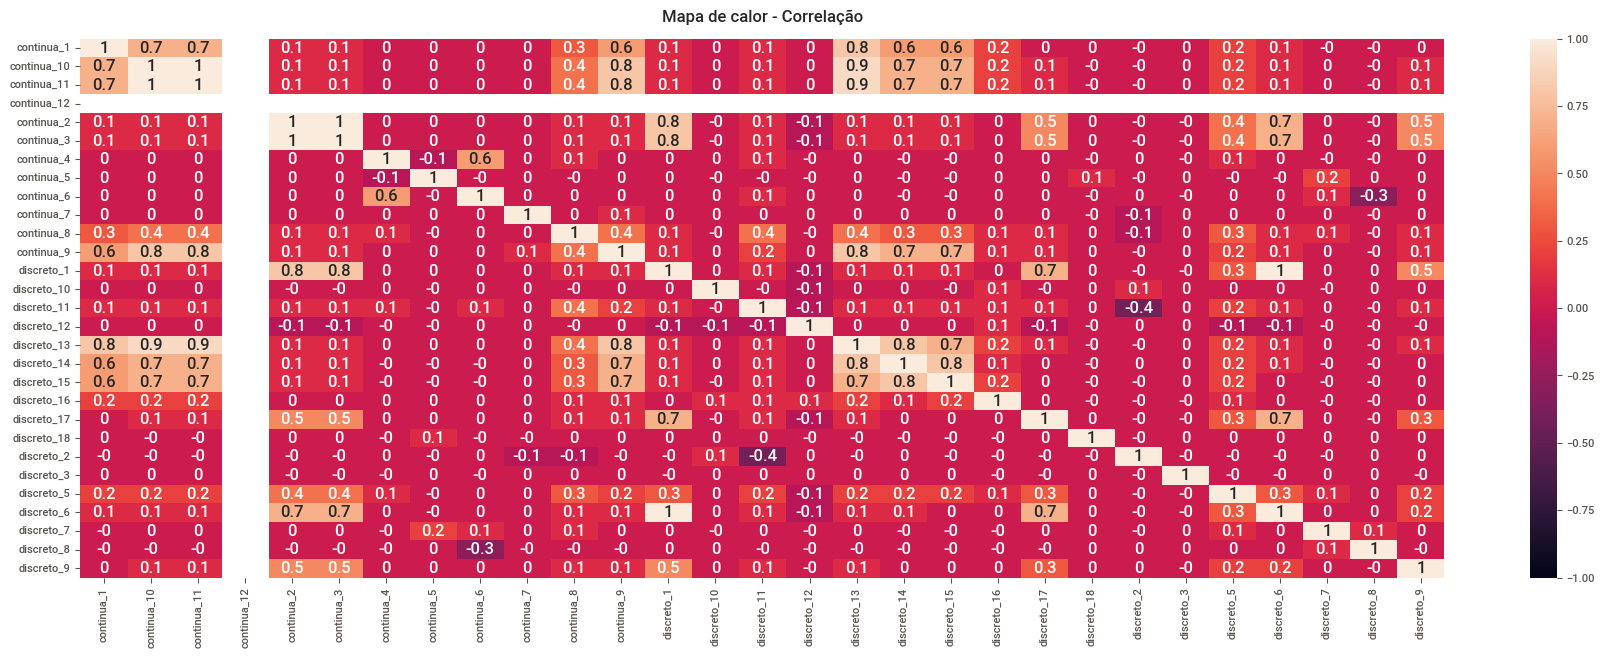

In [100]:
plt.figure(figsize=(22, 7))
heatmap = sns.heatmap(corr, vmin=-1, vmax=1, annot=True)
heatmap.set_title("Mapa de calor - Correlação", fontdict={"fontsize": 12}, pad=12);

# 3 - Feature selection

## 3.1. Filtragem de linhas

In [101]:
# num = ['continua_1', 'continua_10', 'continua_11', 'continua_12', 'continua_2',
#        'continua_3', 'continua_4', 'continua_5', 'continua_6', 'continua_7',
#        'continua_8', 'continua_9', 'discreto_1', 'discreto_10', 'discreto_11',
#        'discreto_12', 'discreto_13', 'discreto_14', 'discreto_15', 'discreto_16', 
#        'discreto_17', 'discreto_18', 'discreto_2', 'discreto_3', 'discreto_5', 
#        'discreto_6', 'discreto_7', 'discreto_8', 'discreto_9']

# # Substituindo valores -999 (faltantes?) pela mediana
# for col in num:
#     df2[col] = df2[col].apply(lambda x: df2[col].median() if x == -999 else x)

## 3.2. Filtragem de colunas

In [102]:
# # Exclusão das features com muitos valores -999 (faltantes?), acima de 80%
# # Exclusão das features com baixa variância
# # Exclusão das features altamente correlacionadas, acima de .8
# df3 = df2.drop(
#     columns=[
#         "continua_2",
#         "continua_12",
#         "continua_3",
#         "continua_10",
#         "discreto_13",
#         "discreto_1",
#         "continua_11",
#         "discreto_14",
#     ]
# )


# >>>>> --- Descartado por não apresentar o melhor resultado ---=== <<<<<<
# df3 = df2.drop(
#     columns=["continua_2","continua_12","continua_3","continua_10",
#         "discreto_13","discreto_1","continua_11","discreto_14",
#         "nominal_8","nominal_9","nominal_10","nominal_11",
#         "nominal_12","nominal_13","nominal_14","nominal_15",
#         "nominal_16","nominal_17","nominal_18","nominal_19",
#         "nominal_20","nominal_21","nominal_22","nominal_23",
#         "nominal_24","nominal_35","nominal_34","nominal_33",
#         "nominal_32","nominal_31","nominal_36",]
# )


# 4 - Data preparation

In [104]:
df3 = df2.copy()

# dividindo em conjunto de treino e teste
X_train, X_test, y_train, y_test = train_test_split(
    df3.drop(["id", "y"], axis=1), df3["y"], test_size=0.2, random_state=42
)

# ======================== PRÉ PROCESSAMENTO ===============================
# pipeline para pré-processamento das variáveis numéricas
num_transformer = Pipeline(steps=[("imputer", SimpleImputer(strategy="median"))])

# pipeline para pré-processamento das variáveis categóricas
cat_transformer = Pipeline(steps=[("label encoder", OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=-1))])

# Compondo os pré-processadores
preprocessor = ColumnTransformer(
    transformers=[
        ("num", num_transformer, list(df3.drop(columns=['id', 'y']).select_dtypes(include=["int32", "float32"]))),
        ("cat", cat_transformer, list(df3.select_dtypes(include=["category"]))),
    ]
)


# 5 - Modeling

## Logistic Regression

c:\Users\Usuário\repos\compass\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\Usuário\repos\compass\lib\site-packages\sklearn\svm\_base.py:1244: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


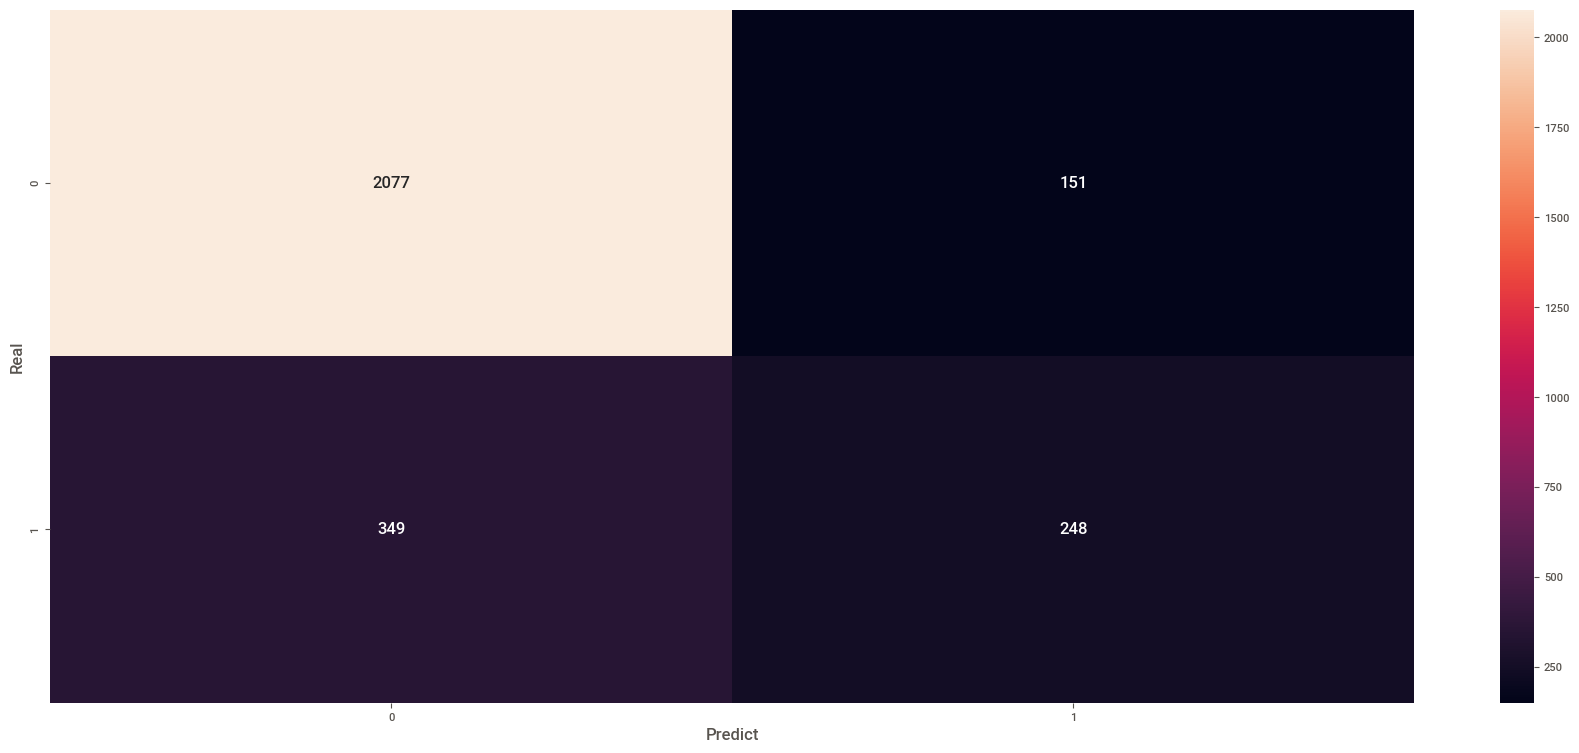

In [109]:
model_name = 'lr'
modelo = LogisticRegression()
parametros = { 
    "max_iter": [1, 5, 10],
    "penalty": ["l2", "l1"],
    "class_weight": ["balanced", None],
    'solver':['liblinear']
}

# O cross validation para descobrir os melhores parametros é realizado no dataset completo
best_params = tuning_hyperparams(preprocessor, modelo, model_name, parametros, df3.drop(["id", "y"], axis=1), df3["y"])

# Usando os melhores parâmetros do Cross validation
model = Pipeline(
    steps=[
        ("preprocessor", preprocessor),
        (
            "lr",
            LogisticRegression(
                class_weight    = best_params[model_name + '__' + "class_weight"],
                max_iter        = best_params[model_name + '__' + "max_iter"],
                penalty         = best_params[model_name + '__' + "penalty"],
                solver          = best_params[model_name + '__' + "solver"],
            ),
        ),
    ]
)

# treinando o modelo
model.fit(X_train, y_train)

# testando o modelo
y_pred = model.predict(X_test)

# Confusion matrix
confusion = pd.crosstab(y_test, y_pred, rownames=['Real'], colnames=['Predict'])
sns.heatmap(confusion, annot=True, fmt='g');

In [52]:
lr_metrics_table = simple_metrics('Logistic Regression', y_test, y_pred)
lr_metrics_table

,Model,Precision,Recall,F1,AUC
0,Logistic Regression,0.63,0.41,0.50,0.67


### 5.0.2. Class balancing

Oversampling

In [ ]:
# >>>>> --- Descartado por não apresentar o melhor resultado ---=== <<<<<<

# from imblearn.over_sampling import SMOTE
# smote = SMOTE(random_state=0)
# X_train, y_train = smote.fit_resample(X_train, y_train)


# >>>>> --- Descartado por não apresentar o melhor resultado ---=== <<<<<<

# from imblearn.over_sampling import RandomOverSampler
# ros = RandomOverSampler(random_state=0, shrinkage=0.1)
# X_train, y_train = ros.fit_resample(X_train, y_train)

Undersampling

In [ ]:
# >>>>> --- Descartado por não apresentar o melhor resultado ---=== <<<<<< 

# from imblearn.under_sampling import RandomUnderSampler
# rus = RandomUnderSampler(random_state=0)
# X_train, y_train = rus.fit_resample(X_train, y_train)


# # >>>>> --- Descartado por não apresentar o melhor resultado ---=== <<<<<<

# from imblearn.under_sampling import TomekLinks
# tl = TomekLinks()
# X_train, y_train = tl.fit_resample(X_train, y_train)

Mix Under/Oversampling

In [ ]:
print(X_train.shape)
print(y_train.shape)


In [ ]:
# >>>>> --- Implementado dentro da função de Cross Validation ---=== <<<<<<
from imblearn.combine import SMOTETomek
smote_tomek = SMOTETomek(random_state=0)
X_train_bal, y_train_bal = smote_tomek.fit_resample(X_train, y_train)

### 5.0.3. Data normalization

RobustScaler

In [ ]:
# >>>>> --- Descartado por não apresentar o melhor resultado ---=== <<<<<<

# rs = RobustScaler()
# rs.fit(X_train)
# X_train_norm = rs.transform(X_train)
# X_test_norm = rs.transform(X_test)

MinMaxScaler

In [ ]:
mms = MinMaxScaler()
mms.fit(X_train)
X_train_norm = mms.transform(X_train)
X_test_norm = mms.transform(X_test)